<a href="https://colab.research.google.com/github/Eezzeldin/candy/blob/main/Interdependence_Propensity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report


In [2]:
df = pd.read_csv ("/content/candy-data.csv")
df

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,45.466282
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,39.011898
82,Welch's Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,44.375519
83,Werther's Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,41.904308


In [3]:

# Define function to calculate propensity scores and perform matching
def propensity_score_matching(df, target_col):
    # Features to be used for prediction (all binary columns excluding the target)
    covariates = [col for col in df.columns if col != target_col and col not in ['competitorname', 'sugarpercent', 'pricepercent', 'winpercent']]

    # Extract covariate matrix and target column
    X = df[covariates]
    y = df[target_col]

    # Standardize covariates
    scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    # Fit logistic regression model to predict target column
    log_reg = LogisticRegression()
    # Hyperparameter grid
    param_dist = {
        'C': np.logspace(-3, 3, 20),
        'penalty': ['l1', 'l2']
    }

    # Define balanced accuracy scorer
    balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)

    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=5,shuffle= True)

    # RandomizedSearchCV for hyperparameter tuning
    randomized_search = RandomizedSearchCV(log_reg, param_distributions=param_dist, scoring=balanced_accuracy_scorer, cv=skf, n_iter=10, random_state=42)
    randomized_search.fit(X, y)


    # Optimal model
    best_model = randomized_search.best_estimator_
    # Predict propensity scores using cross-validation
    predicted_probs_cv = cross_val_predict(best_model, X, y, cv=skf, method='predict_proba')[:, 1]

    # Split the data into treatment and control groups
    treated_indices = df[y == 1].index
    control_indices = df[y == 0].index

    # Nearest neighbor matching
    neighbors = NearestNeighbors(n_neighbors=1)
    neighbors.fit(predicted_probs_cv[control_indices].reshape(-1, 1))

    # Get matched indices for treated samples only
    distances, matched_indices = neighbors.kneighbors(predicted_probs_cv[treated_indices].reshape(-1, 1))

    # Match treated samples to nearest control samples
    matched_control_indices = control_indices[matched_indices.flatten()]

    # Combine treated samples with their matched control samples
    matched_data = pd.concat([df.loc[treated_indices], df.loc[matched_control_indices]])


    return matched_data

# Apply the propensity score matching recursively for each binary column
matched_data = {}
binary_columns = ['chocolate', 'fruity', 'caramel', 'peanutyalmondy', 'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus']

for binary_col in binary_columns:
    matched_data[binary_col] = propensity_score_matching(df, binary_col)

# Display the matched data for one example feature
matched_data['caramel']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
6,Baby Ruth,1,0,1,1,1,0,0,1,0,0.604,0.767,56.914547
9,Caramel Apple Pops,0,1,1,0,0,0,0,0,0,0.604,0.325,34.517681
35,Milk Duds,1,0,1,0,0,0,0,0,1,0.302,0.511,55.064072
36,Milky Way,1,0,1,0,1,0,0,1,0,0.604,0.651,73.099556
37,Milky Way Midnight,1,0,1,0,1,0,0,1,0,0.732,0.441,60.800701
38,Milky Way Simply Caramel,1,0,1,0,0,0,0,1,0,0.965,0.860,64.353340
56,Rolo,1,0,1,0,0,0,0,0,1,0.860,0.860,65.716286
64,Snickers,1,0,1,1,1,0,0,1,0,0.546,0.651,76.673782
65,Snickers Crisper,1,0,1,1,0,1,0,1,0,0.604,0.651,59.529251


<Axes: >

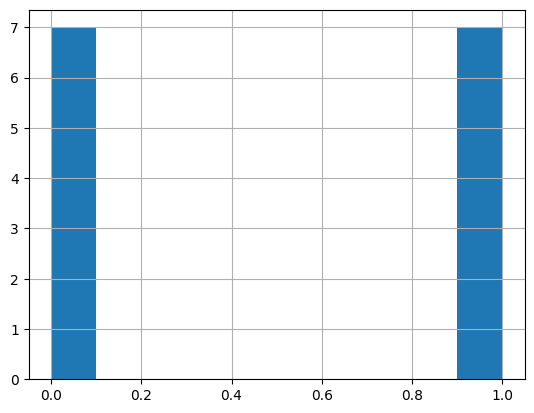

In [4]:
# Display the matched data for one example feature
matched_data['crispedricewafer'] ["crispedricewafer"].hist()


In [5]:
# Function to train and classify using cross-validation for each binary feature
def classify_matched_data_cv(matched_data, cv_splits=5):
    results = {}
    for target_col in matched_data:
        # Extract data and define predictors and target
        data = matched_data[target_col]
        predictors = [col for col in binary_columns if col != target_col]

        # Extract covariate matrix and target column
        X = data[predictors]
        y = data[target_col]

        # Standardize covariates
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Initialize logistic regression model
        log_reg = LogisticRegression(solver='liblinear')

        # Stratified K-Fold cross-validation
        skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

        # Predict using cross-validation
        y_pred = cross_val_predict(log_reg, X_scaled, y, cv=skf)

        # Classification report
        report = classification_report(y, y_pred, target_names=['Control', 'Treated'])
        results[target_col] = report

    return results

# Apply the function for all binary columns in the dataset using cross-validation
classification_results_cv = classify_matched_data_cv(matched_data)



In [6]:
classification_results_cv.keys()

dict_keys(['chocolate', 'fruity', 'caramel', 'peanutyalmondy', 'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus'])

In [7]:
# Display classification results for one of the columns (e.g., 'caramel')
print ( classification_results_cv['chocolate'] )


              precision    recall  f1-score   support

     Control       0.62      0.86      0.72        37
     Treated       0.77      0.46      0.58        37

    accuracy                           0.66        74
   macro avg       0.69      0.66      0.65        74
weighted avg       0.69      0.66      0.65        74



In [31]:
matched_data

{'chocolate':                 competitorname  chocolate  fruity  caramel  peanutyalmondy  \
 0                    100 Grand          1       0        1               0   
 1                 3 Musketeers          1       0        0               0   
 5                   Almond Joy          1       0        0               1   
 6                    Baby Ruth          1       0        1               1   
 10             Charleston Chew          1       0        0               0   
 ..                         ...        ...     ...      ...             ...   
 19           Haribo Happy Cola          0       0        0               0   
 19           Haribo Happy Cola          0       0        0               0   
 83  Werther's Original Caramel          0       0        1               0   
 46                      Payday          0       0        0               1   
 2                     One dime          0       0        0               0   
 
     nougat  crispedricewafer  hard  

In [37]:
for k in matched_data.keys ():
    matched_data [k] ["Key"] = k

In [39]:
pd.concat ( [matched_data [k] for k in matched_data.keys()] )

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent,Key
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725,chocolate
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936,chocolate
5,Almond Joy,1,0,0,1,0,0,0,1,0,0.465,0.767,50.347546,chocolate
6,Baby Ruth,1,0,1,1,1,0,0,1,0,0.604,0.767,56.914547,chocolate
10,Charleston Chew,1,0,0,0,1,0,0,1,0,0.604,0.511,38.975037,chocolate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Super Bubble,0,1,0,0,0,0,0,0,0,0.162,0.116,27.303865,pluribus
29,Laffy Taffy,0,1,0,0,0,0,0,0,0,0.220,0.116,41.389557,pluribus
72,Super Bubble,0,1,0,0,0,0,0,0,0,0.162,0.116,27.303865,pluribus
29,Laffy Taffy,0,1,0,0,0,0,0,0,0,0.220,0.116,41.389557,pluribus


In [50]:
matched_data ["hard"] [matched_data ["hard"] ["hard"] == 0]

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent,Key
72,Super Bubble,0,1,0,0,0,0,0,0,0,0.162,0.116,27.303865,hard
72,Super Bubble,0,1,0,0,0,0,0,0,0,0.162,0.116,27.303865,hard
34,Mike & Ike,0,1,0,0,0,0,0,0,1,0.872,0.325,46.411716,hard
34,Mike & Ike,0,1,0,0,0,0,0,0,1,0.872,0.325,46.411716,hard
29,Laffy Taffy,0,1,0,0,0,0,0,0,0,0.220,0.116,41.389557,hard
13,Dots,0,1,0,0,0,0,0,0,1,0.732,0.511,42.272076,hard
11,Chewey Lemonhead Fruit Mix,0,1,0,0,0,0,0,0,1,0.732,0.511,36.017628,hard
29,Laffy Taffy,0,1,0,0,0,0,0,0,0,0.220,0.116,41.389557,hard
70,Sugar Babies,0,0,1,0,0,0,0,0,1,0.965,0.767,33.437550,hard
12,Chiclets,0,1,0,0,0,0,0,0,1,0.046,0.325,24.524988,hard


In [40]:
pd.concat ( [matched_data [k] for k in matched_data.keys()] ).to_csv ("matched_data_xyz123.csv")

In [41]:
# Function to train and classify using cross-validation for each binary feature
def classify_matched_data_cv(matched_data, cv_splits=5):
    results = {}
    for target_col in matched_data:
        # Extract data and define predictors and target
        data = matched_data[target_col]
        predictors = data.drop (["competitorname" , target_col , "Key"],axis =1).columns

        # Extract covariate matrix and target column
        X = data[predictors]
        y = data[target_col]

        # Standardize covariates
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Initialize logistic regression model
        log_reg = LogisticRegression(solver='liblinear')

        # Stratified K-Fold cross-validation
        skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

        # Predict using cross-validation
        y_pred = cross_val_predict(log_reg, X_scaled, y, cv=skf)

        # Classification report
        report = classification_report(y, y_pred, target_names=['Control', 'Treated'])
        results[target_col] = report

    return results

# Apply the function for all binary columns in the dataset using cross-validation
classification_results_cv = classify_matched_data_cv(matched_data)



In [46]:
# Display classification results for one of the columns (e.g., 'caramel')
print ( classification_results_cv['peanutyalmondy'] )


              precision    recall  f1-score   support

     Control       0.71      0.71      0.71        14
     Treated       0.71      0.71      0.71        14

    accuracy                           0.71        28
   macro avg       0.71      0.71      0.71        28
weighted avg       0.71      0.71      0.71        28

